In [2]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
#from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#from sklearn.model_selection import cross_validate, cross_val_score, KFold
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from PIL import Image
from itertools import cycle
import re, math
import seaborn as sns; sns.set_style("white")
#from sklearn.manifold import TSNE
#import umap.umap_ as umap
import datetime
import gc
#from pathlib import Path
#from sklearn.metrics import roc_curve, auc, roc_auc_score
#from statistics import mean
from numpy import median
os.getcwd()

'/home/jovyan/Laura/RMS_e02_v01_analysis_QC'

In [3]:
figformat = 'png'
dpi = 300

In [4]:
color_dict = {'RD':'red','RD18':'orange','RH30':'blue','CW9019':'forestgreen','ABEMACICLIB':"greenyellow", 'ALISERTIB':"fuchsia", 'BERBERINE CHLORIDE':"orange", 'BOSUTINIB':"tomato", 'CAPMATINIB':"indianred", 'CERITINIB':"powderblue", 'CYTOCHALASIN':"coral", 'D-SORBITOL':"yellow", 'DASATINIB':"aquamarine", 'DEQUALINIUM CHLORIDE':"forestgreen", 'DIGOXIN': "orangered", 'DMSO': "grey", 'ERDAFITINIB':"turquoise", 'ETOPOSIDE':"khaki", 'FEDRATINIB':"lawngreen", 'FENBENDAZOLE':"purple", 'FLUPHENAZINE':"grey", 'GELDANAMYCIN':"aqua", 'INDINAVIR':"peru", 'LORLATINIB':"crimson", 'METHOTREXATE':"dodgerblue", 'METOCLOPRAMID':"gold", 'MIDOSTAURIN':"lime", 'NINTEDANIB':"violet", 'NIRAPARIB':"darkorchid", 'PANOBINOSTAT':"olive", 'PLERIXAFOR':"cadetblue", 'PONATINIB':"plum", 'ROFLUMILAST':"slateblue", 'ROMIDEPSIN':"deepskyblue", 'RUXOLITINIB':"cornflowerblue", 'SIROLIMUS':"lemonchiffon", 'SORAFENIB': "rosybrown", 'SOTRASTAURIN': "rebeccapurple", 'TERAZOSIN':"indigo", 'TETRANDRINE':"deeppink", 'VOLASERTIB':"navy", 'VORINOSTAT':"teal", 'YOHIMBINE':"mediumvioletred","UNTREATED":'red'}

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# written by Maris Lapins
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 1.5,
        height=ell_radius_y * 1.5,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
BaseDir = '/home/jovyan/Laura/RMS_e02_v01_analysis_QC'
sorted(os.listdir(BaseDir))

['.ipynb_checkpoints',
 'Plots_CW9019',
 'Plots_CellCount',
 'Plots_Heat_Clustermap',
 'Plots_PCA',
 'Plots_RD',
 'Plots_RD18',
 'Plots_RH30',
 'Plots_thesis',
 'RMS-e02-v01-CW9019.ipynb',
 'RMS-e02-v01-Heatmap_Clustermap_Pearson.ipynb',
 'RMS-e02-v01-PCA-Copy1.ipynb',
 'RMS-e02-v01-PCA.ipynb',
 'RMS-e02-v01-RD.ipynb',
 'RMS-e02-v01-RD18.ipynb',
 'RMS-e02-v01-RH30.ipynb',
 'RMS-e02-v01-cell_count.ipynb',
 'RMS-e02-v01-plots-thesis-Copy1.ipynb',
 'RMS-e02-v01-plots-thesis_small.ipynb',
 'RMS_e02_v01_raw_data_QC.csv',
 'RMS_e02_v01_raw_data_filtered_QC.csv']

In [8]:
InputFiles = []
NameContains = input("Enter part of name(s) of the files:") # e.g.: .*all_per_well.*, .*raw_data_QC.*
for f in (f for f in os.listdir(BaseDir) if re.match(NameContains, f)):
    InputFiles.append(f)
print ('InputFiles: ' + str(InputFiles))

Enter part of name(s) of the files: .*raw_data_QC.*


InputFiles: ['RMS_e02_v01_raw_data_QC.csv']


In [9]:
OutputDir = input("Enter name for output folder: ") # e.g.: Plots
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

Enter name for output folder:  Plots_thesis


In [10]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-01-06 14:27:46


In [11]:
df =  pd.DataFrame()
for file in InputFiles:
            print(file)
            DataFromOneFile =  pd.read_csv('{}/{}'.format(BaseDir, file), sep=",", low_memory=False)
            print(DataFromOneFile.shape)
            df = df.append(DataFromOneFile.iloc[:,:], ignore_index=True)
            print(df.shape)

RMS_e02_v01_raw_data_QC.csv
(2122, 2177)
(2122, 2177)


In [12]:
df.head(1)

,plate_name,well,cmpdname,cmpdnum,cell_line,plate_layout,Image_Metadata_Well,Image_Count_nuclei_filtered_Mean,Image_Count_nuclei_filtered_Sum,Count_nuc_normalized,...,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_2,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_4,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_6,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_8,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_1,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_3,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_5,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_7,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_9,Image_Metadata_Barcode
0,RMS_e02_v01_P014561,A13,UNTREATED,UNTREATED,RD,RMS_e02_v01_layout1,A13,253,1516,130.678266,...,-0.014206,0.022061,-0.039063,-0.017516,0.019926,0.080927,-0.014175,-0.006519,-0.058222,RMS-e02-v01-P014561-RD-48h


In [13]:
CompoundNames = sorted(list(set(df['cmpdname'])))
CompoundNames.remove('UNTREATED')
print(CompoundNames)
cmpdnum = sorted(list(set(df['cmpdnum'])))
WellList = sorted(list(set(df.well)))
print(len(CompoundNames))

['ABEMACICLIB', 'ALISERTIB', 'BERBERINE CHLORIDE', 'BOSUTINIB', 'CAPMATINIB', 'CERITINIB', 'CYTOCHALASIN', 'D-SORBITOL', 'DASATINIB', 'DEQUALINIUM CHLORIDE', 'DIGOXIN', 'DMSO', 'ERDAFITINIB', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'FLUPHENAZINE', 'GELDANAMYCIN', 'INDINAVIR', 'LORLATINIB', 'METHOTREXATE', 'METOCLOPRAMID', 'MIDOSTAURIN', 'NINTEDANIB', 'NIRAPARIB', 'PANOBINOSTAT', 'PLERIXAFOR', 'PONATINIB', 'ROFLUMILAST', 'ROMIDEPSIN', 'RUXOLITINIB', 'SIROLIMUS', 'SORAFENIB', 'SOTRASTAURIN', 'TERAZOSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'YOHIMBINE']
39


In [14]:
Plates = sorted(list(set(df['plate_name'])))
NrOfPlates = len(Plates)
print('Number of plates: %s' %(NrOfPlates))
CellLines_4 = sorted(list(set(df['cell_line'])))
CellLines = CellLines_4.copy()
CellLines.remove('CW9019')
NrOfCellLines = len(CellLines_4)
print('Number of cell lines: %s' %(NrOfCellLines))
Wells = sorted(list(set(df['well'])))
NrOfWells = len(Wells)
print('Number of wells: %s' %(NrOfWells))
Rows = sorted(list(set([w[0] for w in Wells])))
print(*Rows)
NrOfRows = len(Rows)
Columns = sorted(list(set([w[1:] for w in Wells])))
NrOfColumns = len(Columns)
print(*Columns)
df['PlateCellLine'] = df.plate_name + '_' + df.cell_line

Number of plates: 6
Number of cell lines: 4
Number of wells: 384
A B C D E F G H I J K L M N O P
01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [15]:
for OneCellLine in CellLines_4: 
    dfPart=df[(df['cell_line'] == OneCellLine)]
    CompoundNames_cell = sorted(list(set(dfPart['cmpdname'])))
    CompoundNames_cell.remove('UNTREATED')
    filtered_out= list()
    for cmpd in CompoundNames: 
        if not cmpd in CompoundNames_cell: 
            filtered_out.append(cmpd)
    print('Compounds that were filtered out in QC for {}:'.format(OneCellLine) + str(filtered_out))

Compounds that were filtered out in QC for CW9019:['DIGOXIN', 'PANOBINOSTAT', 'ROMIDEPSIN']
Compounds that were filtered out in QC for RD:['ROMIDEPSIN']
Compounds that were filtered out in QC for RD18:[]
Compounds that were filtered out in QC for RH30:['PANOBINOSTAT']


In [16]:
RMS_type = []
RMS_class= []
for cell_line in df['cell_line']: 
    if cell_line in ['RD', 'RD18']:
        RMS_type.append('ERMS')
        RMS_class.append(0)
    else: 
        RMS_type.append('RH30')
        RMS_class.append(1)
df['RMS_type'] = RMS_type
df['RMS_class'] = RMS_class


In [17]:
df.head(3)

,plate_name,well,cmpdname,cmpdnum,cell_line,plate_layout,Image_Metadata_Well,Image_Count_nuclei_filtered_Mean,Image_Count_nuclei_filtered_Sum,Count_nuc_normalized,...,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_8,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_1,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_3,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_5,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_7,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_9,Image_Metadata_Barcode,PlateCellLine,RMS_type,RMS_class
0,RMS_e02_v01_P014561,A13,UNTREATED,UNTREATED,RD,RMS_e02_v01_layout1,A13,253,1516,130.678266,...,-0.017516,0.019926,0.080927,-0.014175,-0.006519,-0.058222,RMS-e02-v01-P014561-RD-48h,RMS_e02_v01_P014561_RD,ERMS,0
1,RMS_e02_v01_P014561,A14,UNTREATED,UNTREATED,RD,RMS_e02_v01_layout1,A14,236,942,121.897513,...,-0.052348,-0.119905,0.032082,-0.123376,-0.068357,0.054154,RMS-e02-v01-P014561-RD-48h,RMS_e02_v01_P014561_RD,ERMS,0
2,RMS_e02_v01_P014561,A15,UNTREATED,UNTREATED,RD,RMS_e02_v01_layout1,A15,228,1369,117.765394,...,0.051850,-0.036952,0.078146,0.067601,0.027983,-0.014265,RMS-e02-v01-P014561-RD-48h,RMS_e02_v01_P014561_RD,ERMS,0


### Feature selection

In [18]:
numeric_columns = list()
for a in df.columns:
    if (df.dtypes[a] == 'float64') | (df.dtypes[a] == 'int64') :
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

Found 2167 numeric columns


In [19]:
feature_columns = [fc for fc in numeric_columns if ('Metadata' not in fc) & ('Number' not in fc) & ('Count' not in fc)& ('class' not in fc)]
print('Excluded columns that are "Metadata", "Number", etc.: {}'.format(len(feature_columns)))
X = df.loc[:, feature_columns].copy()
Xvarying = X.loc[:, ((X.std() > 0.001) & (X.std() < 100000))].copy()
del X
gc.collect()
print('Excluded features with SD < 0.001 and SD > 100000: {}'.format(Xvarying.shape[1]))
Xvarying.dropna(axis=1, inplace=True)
print('Removed features with missing values: {}'.format(Xvarying.shape[1]))
varying_features = list(Xvarying.columns)
Xvarying.tail()

Excluded columns that are "Metadata", "Number", etc.: 2155
Excluded features with SD < 0.001 and SD > 100000: 1673
Removed features with missing values: 1673


,Nuclei_AreaShape_Area,Nuclei_AreaShape_BoundingBoxArea,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,Nuclei_AreaShape_BoundingBoxMinimum_X,Nuclei_AreaShape_BoundingBoxMinimum_Y,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_Eccentricity,...,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_0,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_2,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_4,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_6,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_8_8,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_1,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_3,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_5,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_7,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_9_9
2117,3329.236328,4854.687500,1123.205078,1125.847656,1056.062500,1057.226562,1089.111609,1090.955056,1.307973,0.692978,...,-0.242843,-0.030253,-0.020775,-0.024418,0.011245,-0.084894,0.010986,0.088716,0.154077,0.013563
2118,3323.633094,5044.935252,1310.748201,1174.258993,1244.928058,1104.834532,1277.596097,1139.123335,1.309728,0.699509,...,0.045530,-0.009672,0.022829,0.012538,0.050073,0.319908,-0.148904,0.125408,-0.081444,0.196109
2119,3269.417191,4789.486373,1143.595388,1104.352201,1075.870021,1037.272537,1109.223520,1070.361141,1.290989,0.707606,...,0.023149,0.128590,-0.103942,0.047442,0.039716,0.276506,-0.060465,-0.060720,-0.000096,0.031017
2120,3455.827869,5036.983607,1027.819672,1005.573770,957.352459,936.950820,991.898359,970.676300,1.300202,0.697279,...,-0.142800,0.024688,-0.128433,-0.164680,0.107500,0.194807,0.105175,0.089791,-0.076090,-0.054196
2121,3260.467213,4701.975410,1128.235656,1146.604508,1061.827869,1079.163934,1094.452901,1112.340233,1.283864,0.693057,...,-0.103003,-0.038212,0.123832,0.044550,0.137647,0.110850,0.103563,0.110547,0.031278,-0.083419


### Figure 1 

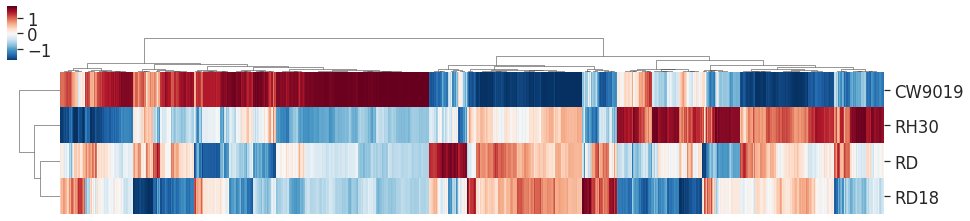

In [20]:
dfPart=df[(df['cmpdname'] == 'UNTREATED')] 


dictOfnumeric = { i : np.nanmean for i in varying_features}
groupedby = dfPart.groupby('cell_line').agg(dictOfnumeric)
x = groupedby.iloc[:,:].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, index = groupedby.index)

sns.set(font_scale=1.5)
sns_plot = sns.clustermap(x, method='ward', metric='euclidean',z_score=None,
                   standard_scale=None,  cbar_kws=None,  
                   row_cluster=True, col_cluster=True,
                    figsize = (14,3),
                   vmin = None, vmax=None,
                   cbar_pos=(0.01, 0.8, 0.01, 0.25),
                   dendrogram_ratio = (0.05, 0.2),
                   row_linkage=None, col_linkage=None, row_colors=None,
                   col_colors=None, cmap="RdBu_r", xticklabels=False)
ax = sns_plot.ax_heatmap
ax.set_ylabel("")
sns_plot.savefig('{}/Clustermap_all_cell_lines.{}'.format(OutputDir, figformat),  dpi=dpi, bbox_inches='tight')


### Figure 2: PCA for untreated in all cell lines

In [21]:
print(df.shape)
dfPart=df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'Placeholder')] #Exclude/include some compounds or cell lines
print(dfPart.shape)
dfPart.reset_index(inplace=True, drop=True)
x = dfPart.loc[:, varying_features].values

(2122, 2180)
(642, 2180)


In [22]:
pca_4 = PCA(n_components=50)

In [23]:
x = StandardScaler().fit_transform(x)
principalComponents = pca_4.fit_transform(x)

In [24]:
principalDf_4 = pd.DataFrame(data = principalComponents)
principalDf_4.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                            2: 'principal component 3'}, inplace=True)

In [25]:
principalDf_4['cmpdname'] = dfPart['cmpdname']
principalDf_4['cell_line'] = dfPart['cell_line']


RMS_class= []
RMS_type = []
for i in range (0,len(principalDf_4),1):
    if principalDf_4['cell_line'].iloc[i] in ['RD', 'RD18']:
        if principalDf_4['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_class.append(0)
            RMS_type.append('ERMS untreated')
        else:
            RMS_class.append(0)
            RMS_type.append('ERMS + treatment')
    else: 
        if principalDf_4['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_class.append(1)
            RMS_type.append('RH30 untreated')
        else: 
            RMS_class.append(1)
            RMS_type.append('RH30 + treatment')
principalDf_4['RMS_class'] = RMS_class
principalDf_4['RMS_type'] = RMS_type


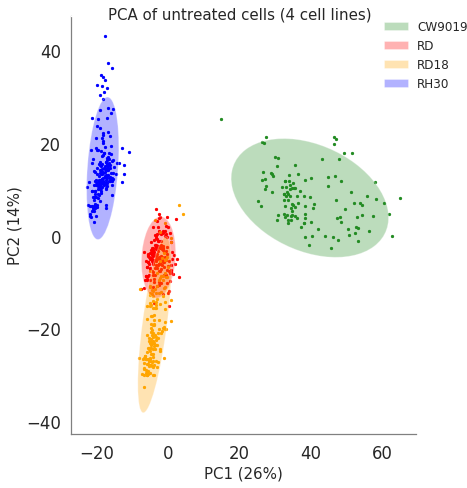

In [26]:
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111) 
ax.set_xlabel('PC1 ({}%)'.format (math.ceil(pca_4.explained_variance_ratio_[0]*100)), fontsize=15)
ax.set_ylabel('PC2 ({}%)'.format (math.ceil(pca_4.explained_variance_ratio_[1]*100)), fontsize=15)
# ax.set_title('Score Scatter Plote', fontsize = 15)

targets = CellLines_4
colors=[]
for target in targets: 
    colors.append(color_dict[target])

for target, color in zip(targets,colors):
    indicesToKeep_ut = principalDf_4['cell_line'] == target
    ax.scatter(principalDf_4.loc[indicesToKeep_ut, 'principal component 1']
               , principalDf_4.loc[indicesToKeep_ut, 'principal component 2']
               , c = color
               , s = 5)
    confidence_ellipse(principalDf_4.loc[indicesToKeep_ut, 'principal component 1']
               , principalDf_4.loc[indicesToKeep_ut, 'principal component 2'], ax, alpha = 0.3, facecolor=color)

plt.tight_layout()
fig.legend(targets, fontsize = 12, loc="upper right", bbox_to_anchor=(0.95, 0.95), frameon=False)
fig.suptitle('PCA of untreated cells (4 cell lines)', fontsize = 15)
plt.subplots_adjust( wspace=0.3, right = 0.85)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.set_facecolor('w')

fig.savefig('{}/PCA_4_cell_lines_untreated.png'.format(OutputDir),  dpi=150, bbox_inches='tight')
plt.show()

In [27]:
print(df.shape)
dfPart=df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'CW9019')] #Exclude/include some compounds or cell lines
CellLines = sorted(list(set(dfPart['cell_line'])))
print(dfPart.shape)
dfPart.reset_index(inplace=True, drop=True)
x = dfPart.loc[:, varying_features].values

(2122, 2180)
(523, 2180)


In [28]:
pca = PCA(n_components=3)

In [29]:
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)

In [30]:
principalDf_ut = pd.DataFrame(data = principalComponents)
principalDf_ut.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                            2: 'principal component 3'}, inplace=True)

In [31]:
principalDf_ut['cmpdname'] = dfPart['cmpdname']
principalDf_ut['cell_line'] = dfPart['cell_line']


RMS_class= []
RMS_type = []
for i in range (0,len(principalDf_ut),1):
    if principalDf_ut['cell_line'].iloc[i] in ['RD', 'RD18']:
        if principalDf_ut['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_class.append(0)
            RMS_type.append('ERMS untreated')
        else:
            RMS_class.append(0)
            RMS_type.append('ERMS + treatment')
    else: 
        if principalDf_ut['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_class.append(1)
            RMS_type.append('RH30 untreated')
        else: 
            RMS_class.append(1)
            RMS_type.append('RH30 + treatment')
principalDf_ut['RMS_class'] = RMS_class
principalDf_ut['RMS_type'] = RMS_type


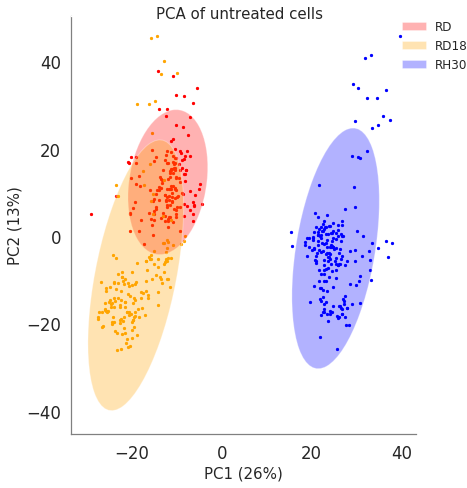

In [32]:
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111) 
ax.set_xlabel('PC1 ({}%)'.format (math.ceil(pca.explained_variance_ratio_[0]*100)), fontsize=15)
ax.set_ylabel('PC2 ({}%)'.format (math.ceil(pca.explained_variance_ratio_[1]*100)), fontsize=15)
# ax.set_title('Score Scatter Plote', fontsize = 15)

targets = CellLines
colors=[]
for target in targets: 
    colors.append(color_dict[target])

for target, color in zip(targets,colors):
    indicesToKeep_ut = principalDf_ut['cell_line'] == target
    ax.scatter(principalDf_ut.loc[indicesToKeep_ut, 'principal component 1']
               , principalDf_ut.loc[indicesToKeep_ut, 'principal component 2']
               , c = color
               , s = 5)
    confidence_ellipse(principalDf_ut.loc[indicesToKeep_ut, 'principal component 1']
               , principalDf_ut.loc[indicesToKeep_ut, 'principal component 2'], ax, alpha = 0.3, facecolor=color)

plt.tight_layout()
fig.legend(targets, fontsize = 12, loc="upper right", bbox_to_anchor=(0.95, 0.95), frameon=False)
fig.suptitle('PCA of untreated cells', fontsize = 15)
plt.subplots_adjust( wspace=0.3, right = 0.85)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.set_facecolor('w')

fig.savefig('{}/PCA_3_cell_lines_untreated.png'.format(OutputDir),  dpi=150, bbox_inches='tight')
plt.show()


### Figure 3: PCA for single cell lines (and S1 &2 S2)

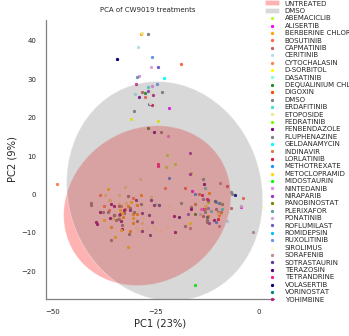

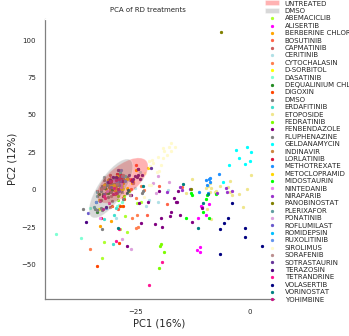

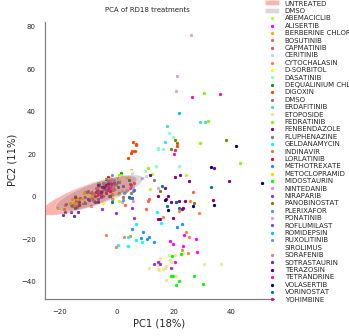

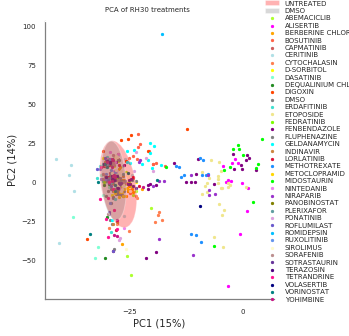

In [42]:
for OneCellLine in CellLines_4:
    dfPart= df[df['cell_line'] == OneCellLine].copy()
    dfPart.reset_index(inplace=True, drop=True)
    x = dfPart.loc[:, varying_features].values
    x = StandardScaler().fit_transform(x)
    pca_cell = PCA(n_components=50)
    principalComponents = pca_cell.fit_transform(x)

    principalDf = pd.DataFrame(data = principalComponents)
    principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                                2: 'principal component 3'}, inplace=True)

    principalDf['cmpdname'] = dfPart['cmpdname']
    principalDf['cmpdnum'] = dfPart['cmpdnum']
    principalDf['cell_line'] = dfPart['cell_line']
    fig = plt.figure(figsize = (5,5))

    ax = fig.add_subplot(111) 
    ax.set_xlabel('PC1 ({}%)'.format (math.ceil(pca_cell.explained_variance_ratio_[0]*100)), fontsize=10)
    ax.set_ylabel('PC2 ({}%)'.format (math.ceil(pca_cell.explained_variance_ratio_[1]*100)), fontsize=10)

    targets = CompoundNames
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 5)
        #confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
        #           , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)


    targets = ['UNTREATED', 'DMSO']
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        #ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
         #          , principalDf.loc[indicesToKeep, 'principal component 2']
          #         , c = color
           #        , s = 5)
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)   
        
    targets= ['UNTREATED', 'DMSO'] + CompoundNames
    plt.tight_layout()
    fig.legend(targets, fontsize = 7, bbox_to_anchor=(1.05,0.95),labelspacing = 0.2,ncol=1, frameon=False)
    fig.suptitle('PCA of {} treatments'.format(OneCellLine), fontsize = 7)
    plt.subplots_adjust( wspace=0.3, right = 0.85)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_facecolor('w')

    fig.savefig('{}/PCA_cell_line_{}.png'.format(OutputDir, OneCellLine),bbox_inches='tight',  dpi=300)
    plt.show()

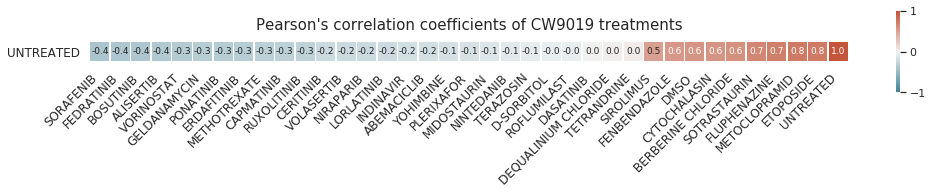

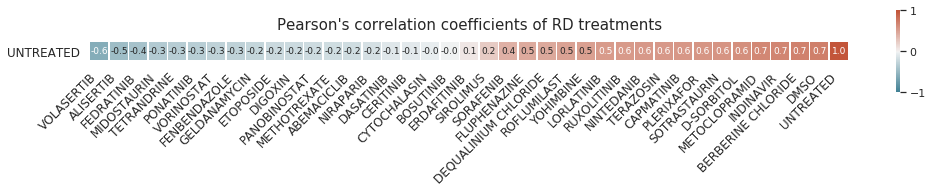

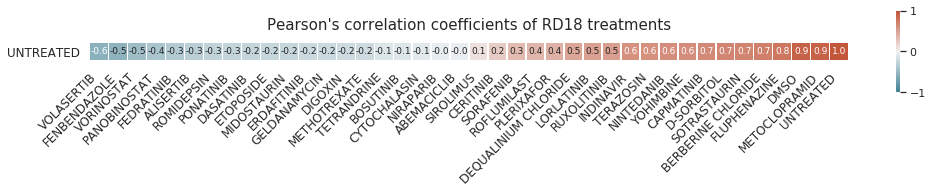

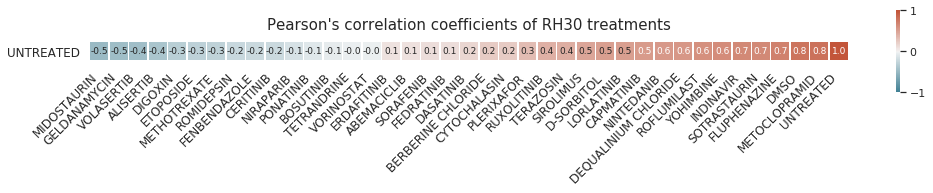

In [227]:
for OneCellLine in CellLines_4:
    dfPart = df[(df['cell_line'] == OneCellLine)] 
    #dfPart['cell_cmpd'] = dfPart.cell_line + ' ' + dfPart.cmpdname
    #dfPart=df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'CW9019')| (df['cell_line'] == 'RH30')]
    #dfPart =dfPart[dfPart['cmpdname'].isin(hits_ut)]

    dictOfnumeric = { i : np.nanmean for i in varying_features}
    groupedby = dfPart.groupby('cmpdname').agg(dictOfnumeric)
    x = groupedby.iloc[:,:].values
    x = StandardScaler().fit_transform(x)
    x = pd.DataFrame(x, index = groupedby.index)
    CorrMatrics = x.T.corr()
    CorrMatrics = CorrMatrics.loc[['UNTREATED'],:] 
    sns.set(font_scale=1)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(17,5)) 

    #mask = np.triu(np.ones_like(CorrMatrics, dtype=np.bool))
    #for a in range(mask.shape[0]):
    #    mask[a, a] = False

    sns.heatmap(CorrMatrics.sort_values(by='UNTREATED', axis=1), vmin=-1, vmax=1, linewidths=.5, ax = ax, fmt='.1f',annot_kws={'size': 9},
                     annot=True, 
                     cmap=sns.diverging_palette(220, 20, n=200),
                     cbar_kws={"shrink": 0.3},
                 square=True
                    )

    ax.set_title('Pearson\'s correlation coefficients of {} treatments'.format(OneCellLine), fontdict={'fontsize':15}, pad=12)
    ax.set(xlabel=None, ylabel=None)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right', fontsize = 12);
    ax.set_yticklabels(ax.get_yticklabels(),
        rotation=0, fontsize = 12);

    fig.savefig('{}/CorrelationMatrix_{}.{}'.format(OutputDir,OneCellLine, 'png'),  dpi=300)

['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT']
['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'UNTREATED', 'DMSO']


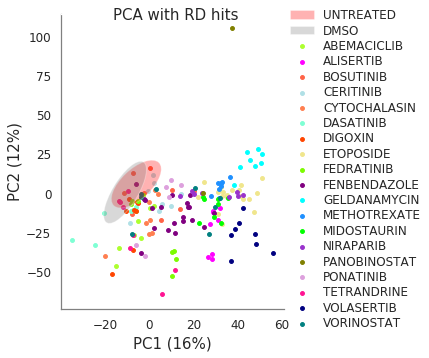

['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ERDAFITINIB', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT']
['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ERDAFITINIB', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'UNTREATED', 'DMSO']


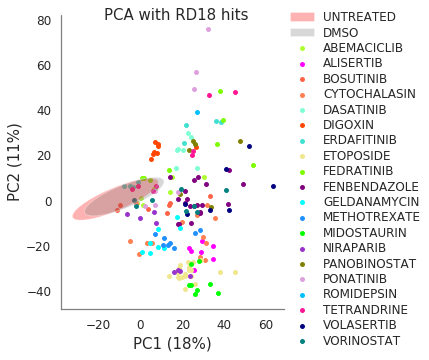

['ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'DIGOXIN', 'ETOPOSIDE', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT']
['ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'DIGOXIN', 'ETOPOSIDE', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'UNTREATED', 'DMSO']


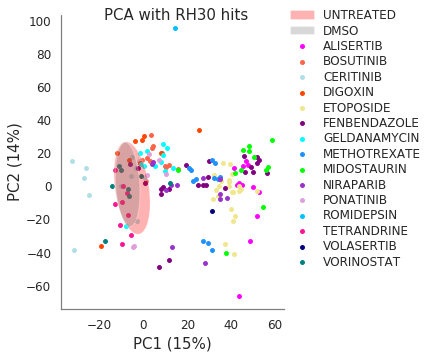

In [241]:
for OneCellLine in CellLines: 
    dfPart= df[df['cell_line'] == OneCellLine].copy()
    dfPart.reset_index(inplace=True, drop=True)
    x = dfPart.loc[:, varying_features].values
    x = StandardScaler().fit_transform(x)
    pca_cell = PCA(n_components=50)
    principalComponents = pca_cell.fit_transform(x)

    principalDf = pd.DataFrame(data = principalComponents)
    principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                                2: 'principal component 3'}, inplace=True)

    principalDf['cmpdname'] = dfPart['cmpdname']
    principalDf['cmpdnum'] = dfPart['cmpdnum']
    principalDf['cell_line'] = dfPart['cell_line']
    dictOfnumeric = { i : np.nanmean for i in varying_features}
    groupedby = dfPart.groupby('cmpdname').agg(dictOfnumeric)
    x = dfPart.loc[:, varying_features].values
    x = groupedby.iloc[:,:].values
    x = StandardScaler().fit_transform(x)
    x = pd.DataFrame(x, index = groupedby.index)
    CorrMatrics = x.T.corr()
     
    hits_pcc = []
    for column in CorrMatrics.columns:
        if CorrMatrics.loc['UNTREATED', column] < 0.0: 
            hits_pcc.append(column)
        else: 
            continue
    hits_ut = hits_pcc.copy() 
    hits_ut.append('UNTREATED')
    hits_ut.append('DMSO')
    print(hits_pcc)
    print(hits_ut)
    
    fig = plt.figure(figsize = (5,5))

    ax = fig.add_subplot(111) 
    ax.set_xlabel('PC1 ({}%)'.format (math.ceil(pca_cell.explained_variance_ratio_[0]*100)), fontsize=15)
    ax.set_ylabel('PC2 ({}%)'.format (math.ceil(pca_cell.explained_variance_ratio_[1]*100)), fontsize=15)
    targets = hits_pcc
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 15)
        #confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
        #           , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)


    targets = ['UNTREATED', 'DMSO']
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 0)
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)    
    targets= ['UNTREATED', 'DMSO'] + hits_pcc
    plt.tight_layout()
    fig.legend(targets, fontsize = 12,bbox_to_anchor=(1.2, 1.0),labelspacing = 0.2, frameon=False)
    plt.subplots_adjust(wspace=0.3, right = 0.80)
    fig.suptitle('PCA with {} hits'.format(OneCellLine), fontsize = 15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_facecolor('w')

    fig.savefig('{}/PCA_cell_line_{}_hits_pcc.png'.format(OutputDir, OneCellLine), bbox_inches='tight', dpi=300)
    plt.show()


### Supplementary Figure 

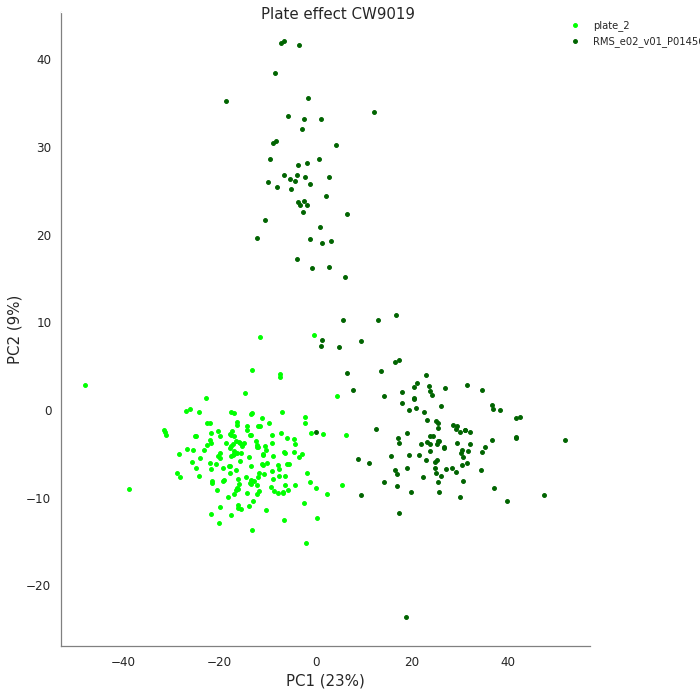

In [43]:
OneCellLine = 'CW9019'
CW9019_Plates = ['plate_2','RMS_e02_v01_P014564']
dfPart= df[df['cell_line'] == OneCellLine].copy()
dfPart.reset_index(inplace=True, drop=True)
x = dfPart.loc[:, varying_features].values
x = StandardScaler().fit_transform(x)
pca_cell = PCA(n_components=3)
principalComponents = pca_cell.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents)
principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                            2: 'principal component 3'}, inplace=True)

principalDf['cmpdname'] = dfPart['cmpdname']
principalDf['cell_line'] = dfPart['cell_line']
principalDf['plate_name'] = dfPart['plate_name']
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111) 
ax.set_xlabel('PC1 ({}%)'.format (math.ceil(pca_cell.explained_variance_ratio_[0]*100)), fontsize=15)
ax.set_ylabel('PC2 ({}%)'.format (math.ceil(pca_cell.explained_variance_ratio_[1]*100)), fontsize=15)

targets = CW9019_Plates
colors= ['lime', 'darkgreen']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf['plate_name'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 15)
    #confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
    #           , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)

plt.tight_layout()
fig.legend(targets, fontsize = 10, loc='best', bbox_to_anchor=(1.0, 0.95), frameon=False)
plt.subplots_adjust(wspace=0.3, right = 0.85)
fig.suptitle('Plate effect CW9019'.format(OneCellLine), fontsize = 15)

ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_facecolor('w')

fig.savefig('{}/PCA_cell_line_{}_plate_effect.png'.format(OutputDir, OneCellLine), dpi=300)
plt.show()

In [ ]:
for plate in CW9019_Plates:   
    dfPlate = df[df['plate_name'] == plate].copy()
    OneCellLine = 'CW9019'
    dfPart= dfPlate[dfPlate['cell_line'] == OneCellLine].copy()
    dfPart.reset_index(inplace=True, drop=True)
    PlateCmpd = sorted(list(set(dfPart['cmpdname'])))
    PlateCmpd.remove('UNTREATED')
    x = dfPart.loc[:, varying_features].values
    x = StandardScaler().fit_transform(x)
    pca_cell = PCA(n_components=3)
    principalComponents = pca_cell.fit_transform(x)

    principalDf = pd.DataFrame(data = principalComponents)
    principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                                2: 'principal component 3'}, inplace=True)

    principalDf['cmpdname'] = dfPart['cmpdname']
    principalDf['cell_line'] = dfPart['cell_line']
    fig = plt.figure(figsize = (10,10))

    ax = fig.add_subplot(111) 
    ax.set_xlabel('PC 1', fontsize = 15)
    ax.set_ylabel('PC 2', fontsize = 15)

    targets = PlateCmpd
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 15)
        #confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
        #           , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)


    targets = ['UNTREATED', 'DMSO']

    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 5)
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color)    
    targets= ['UNTREATED', 'DMSO'] + PlateCmpd

    plt.tight_layout()
    fig.legend(targets, fontsize = 10, loc='best', bbox_to_anchor=(1.0, 0.95), frameon=False)
    plt.subplots_adjust(wspace=0.3, right = 0.85)
    plt.subplots_adjust( wspace=0.3, right = 0.85)

    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_facecolor('w')

    fig.savefig('{}/PCA_cell_line_{}_{}.png'.format(OutputDir, OneCellLine, plate), dpi=300)
    plt.show()

### Figure 4 Cluster map  for RH30 treatment (

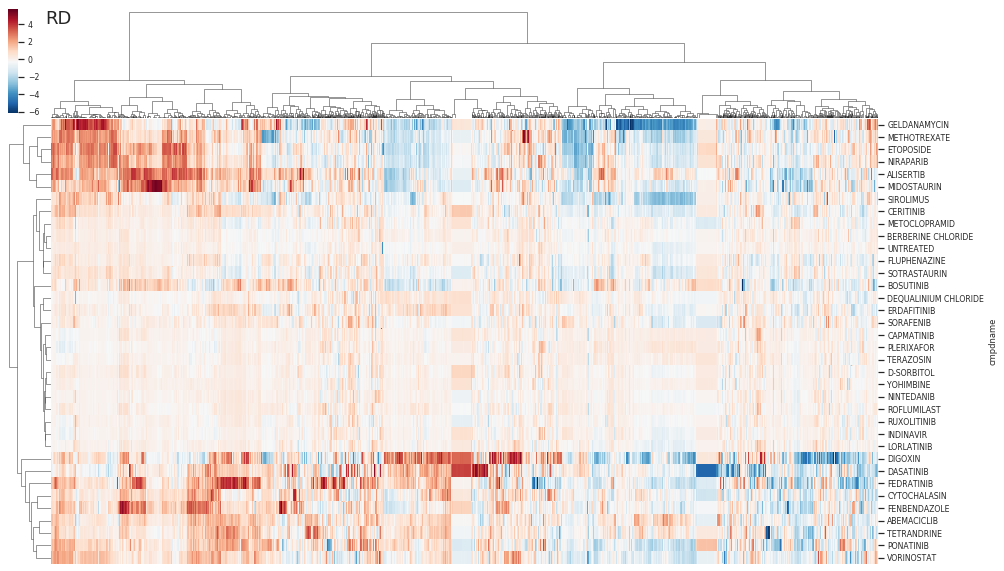

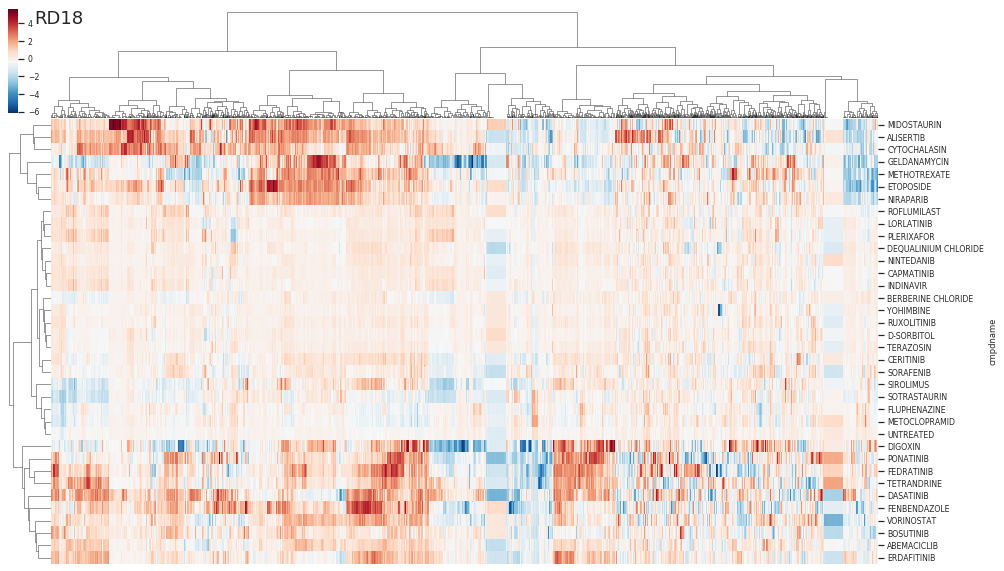

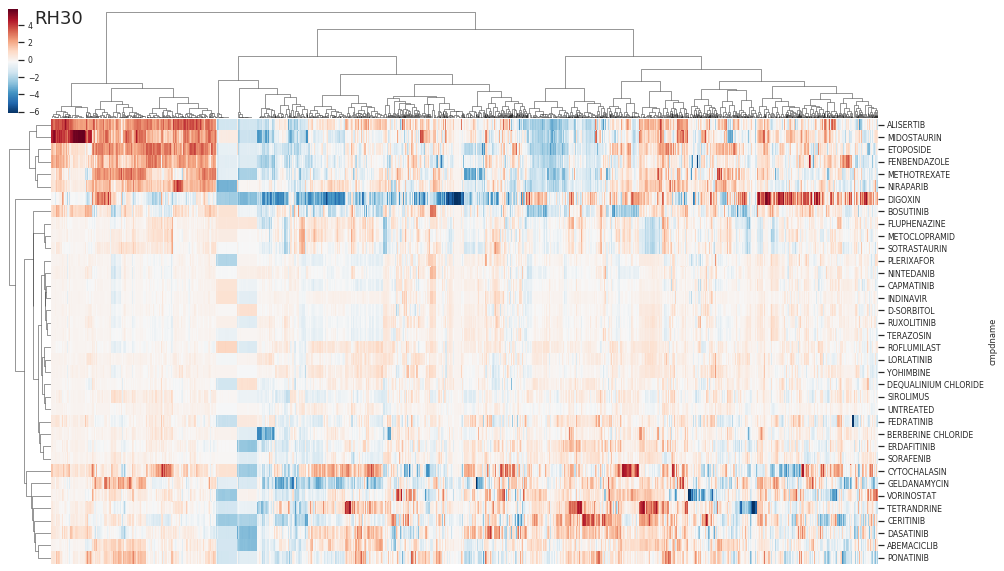

In [37]:
for OneCellLine in CellLines:
    dfPart=df[(df['cell_line'] == OneCellLine) & (df['cmpdname'] != 'ROMIDEPSIN')& (df['cmpdname'] != 'VOLASERTIB')& (df['cmpdname'] != 'PANOBINOSTAT')] 

    dictOfnumeric = { i : np.nanmean for i in varying_features}
    groupedby = dfPart.groupby('cmpdname').agg(dictOfnumeric)
    x = groupedby.iloc[:,:].values
    x = StandardScaler().fit_transform(x)
    x = pd.DataFrame(x, index = groupedby.index)
    x = x - x.loc['DMSO']
    x= x.drop('DMSO')


    sns.set(font_scale=0.7)
    sns_plot = sns.clustermap(x, method='ward', metric='euclidean', z_score=None,
                       standard_scale=None,  cbar_kws=None,  
                       row_cluster=True, col_cluster=True,
                       figsize = (14,8),
                       vmin = None, vmax=None,
                       cbar_pos=(0.01, 0.8, 0.01, 0.18),
                       dendrogram_ratio = (0.05, 0.2),
                       row_linkage=None, col_linkage=None, row_colors=None,
                       col_colors=None, cmap="RdBu_r", xticklabels=False )
    sns_plot.fig.suptitle('{}'.format(OneCellLine), fontsize = 18, x = 0.06)
    plt.show()

    rowname_list = [x.index[row_id] for row_id in sns_plot.dendrogram_row.reordered_ind]
    x = x.reindex(rowname_list)
    CorrMatrics = x.T.corr()
    CorrMatrics = CorrMatrics.loc[['UNTREATED'],:]


    sns_plot.savefig('{}/Clustermap_{}_norm.{}'.format(OutputDir, OneCellLine, figformat),  dpi=dpi, bbox_inches='tight')



### Figure 5 PCA with hits PCC


(908, 2180)
['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT']
['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'UNTREATED', 'DMSO']


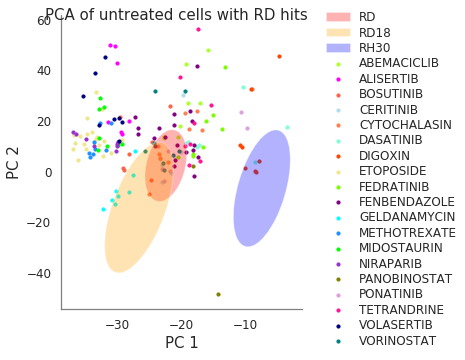

(915, 2180)
['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ERDAFITINIB', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT']
['ABEMACICLIB', 'ALISERTIB', 'BOSUTINIB', 'CYTOCHALASIN', 'DASATINIB', 'DIGOXIN', 'ERDAFITINIB', 'ETOPOSIDE', 'FEDRATINIB', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PANOBINOSTAT', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'UNTREATED', 'DMSO']


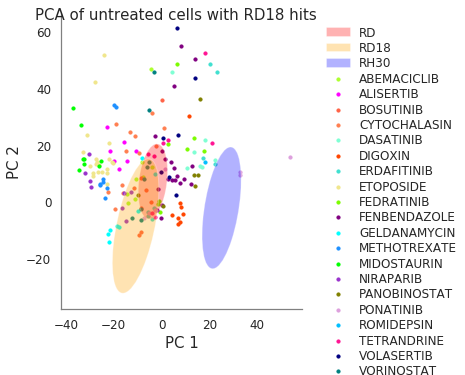

(1020, 2180)
['ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'DIGOXIN', 'ETOPOSIDE', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT']
['ALISERTIB', 'BOSUTINIB', 'CERITINIB', 'DIGOXIN', 'ETOPOSIDE', 'FENBENDAZOLE', 'GELDANAMYCIN', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'PONATINIB', 'ROMIDEPSIN', 'TETRANDRINE', 'VOLASERTIB', 'VORINOSTAT', 'UNTREATED', 'DMSO']


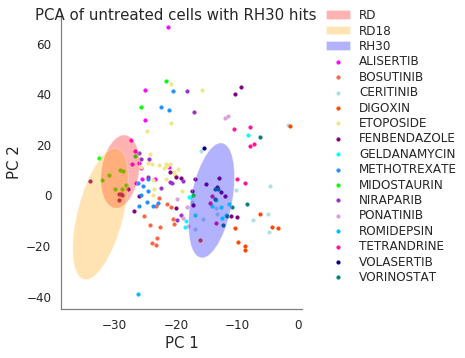

In [220]:
for OneCellLine in CellLines:
    dfPart=df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'CW9019')| (df['cell_line'] == OneCellLine)] 
    print(dfPart.shape)
    dfPart.reset_index(inplace=True, drop=True)
    x = dfPart.loc[:, varying_features].values
    x = StandardScaler().fit_transform(x)
    principalComponents = pca.transform(x)
    principalDf = pd.DataFrame(data = principalComponents)
    principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                                2: 'principal component 3'}, inplace=True)

    principalDf['cmpdname'] = dfPart['cmpdname']
    principalDf['cell_line'] = dfPart['cell_line']
    principalDf['cmpdnum'] = dfPart['cmpdnum']
    
    dfPart= df[df['cell_line'] == OneCellLine].copy()
    dfPart.reset_index(inplace=True, drop=True)
    dictOfnumeric = { i : np.nanmean for i in varying_features}
    groupedby = dfPart.groupby('cmpdname').agg(dictOfnumeric)
    x = dfPart.loc[:, varying_features].values
    x = groupedby.iloc[:,:].values
    x = StandardScaler().fit_transform(x)
    x = pd.DataFrame(x, index = groupedby.index)
    CorrMatrics = x.T.corr()
     
    hits_pcc = []
    for column in CorrMatrics.columns:
        if CorrMatrics.loc['UNTREATED', column] < 0.0: 
            hits_pcc.append(column)
        else: 
            continue
    hits_ut = hits_pcc.copy() 
    hits_ut.append('UNTREATED')
    hits_ut.append('DMSO')
    print(hits_pcc)
    print(hits_ut)

    RMS_class= []
    RMS_type = []
    for i in range (0,len(principalDf),1):
        if principalDf['cell_line'].iloc[i] in ['RD', 'RD18']:
            if principalDf['cmpdname'].iloc[i] == 'UNTREATED':
                RMS_class.append(0)
                RMS_type.append('ERMS untreated')
            else:
                RMS_class.append(0)
                RMS_type.append('ERMS + treatment')
        else: 
            if principalDf['cmpdname'].iloc[i] == 'UNTREATED':
                RMS_class.append(1)
                RMS_type.append('RH30 untreated')
            else: 
                RMS_class.append(1)
                RMS_type.append('RH30 + treatment')

    principalDf['RMS_class'] = RMS_class
    principalDf['RMS_type'] = RMS_type

    fig = plt.figure(figsize = (5,5))

    ax = fig.add_subplot(111) 
    ax.set_xlabel('PC 1', fontsize = 15)
    ax.set_ylabel('PC 2', fontsize = 15)
    # ax.set_title('Score Scatter Plote', fontsize = 15)
    principalDf_ellipse = principalDf[principalDf['cmpdname'] == 'UNTREATED']
    targets = CellLines
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep_ut = principalDf_ellipse['cell_line'] == target

        confidence_ellipse(principalDf_ellipse.loc[indicesToKeep_ut, 'principal component 1']
                   , principalDf_ellipse.loc[indicesToKeep_ut, 'principal component 2'], ax, alpha = 0.3, facecolor=color)


    targets = hits_pcc
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])

    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['cmpdname'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 10)
        #confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
         #              , principalDf.loc[indicesToKeep, 'principal component 2'], ax,n_std=1, alpha = 0.3, facecolor=color)

    targets= CellLines + hits_pcc
    plt.tight_layout()
    fig.legend(targets, fontsize = 12, loc="upper right",  bbox_to_anchor=(1.3,1.0),labelspacing = 0.2, frameon=False)
    fig.suptitle('PCA of untreated cells with {} hits'.format(OneCellLine), fontsize = 15)
    plt.subplots_adjust( wspace=0.3, right = 0.85)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.set_facecolor('w')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    fig.savefig('{}/PCA_3_cell_lines_untreated_and_{}_hits_pcc.png'.format(OutputDir, OneCellLine),  dpi=150, bbox_inches='tight')
    plt.show()

### Figure 6: PC-SVM and PCA with reprogramming hits

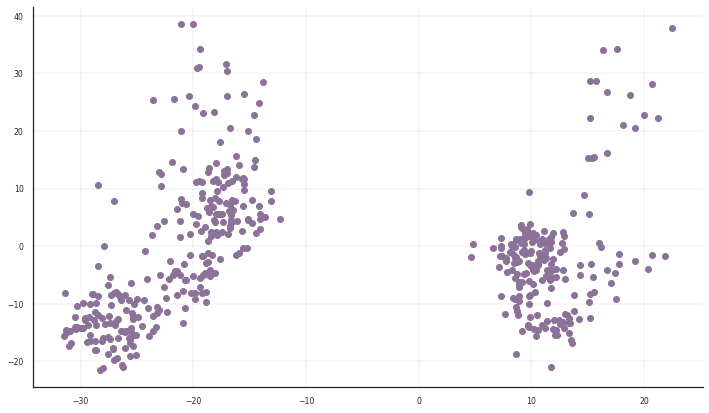

In [39]:
sns.set_style("white")
features = principalDf_ellipse[['principal component 1', 'principal component 2']]
label = principalDf_ellipse['RMS_class']
size= len(label)
# Hold out 10% of the dataset for testing
test_size = int(np.round(size * 0.1, 0))# Split dataset into training and testing sets
x_train = features[:-test_size].values
y_train = label[:-test_size].values
x_test = features[-test_size:].values
y_test = label[-test_size:].values
# Plotting the training set
fig, ax = plt.subplots(figsize=(12, 7))
# removing top and right border

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['right'].set_color('grey')
#ax.spines['bottom'].set_color('grey')
# adding major gridlines

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.scatter(features[:-test_size]['principal component 1'], features[:-test_size]['principal component 2'], c="#8C7298")

plt.show()



In [40]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param = {'C':(0,0.01,0.1,1,2,10)}

model = svm.SVC(kernel='linear', probability=True)
svm.grid = GridSearchCV(model,param,n_jobs=1,cv=4,verbose=1,scoring='accuracy')
svm.grid.fit(x_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid={'C': (0, 0.01, 0.1, 1, 2, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [41]:
C_best = svm.grid.best_params_['C']

In [42]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
model = svm.SVC(C =C_best,kernel='linear', probability=True )
model.fit(x_train, y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

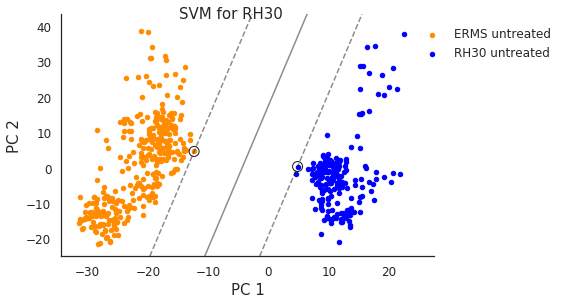

In [191]:
fig, ax = plt.subplots(figsize=(6, 4))
# Removing to and right border
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# Create grid to evaluate model
xx = np.linspace(-26, max(features['principal component 1']) + 5, len(x_train))
yy = np.linspace(-25, max(features['principal component 2']) + 5, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

train_size = len(features[:-test_size]['principal component 1'])
# Assigning different colors to the classes
targets = sorted(list(set(principalDf_ellipse['RMS_type'])))

colors = cycle(['darkorange','blue'])

for target, color in zip(targets,colors):
    indicesToKeep_ut = principalDf_ellipse['RMS_type'] == target
    ax.scatter(principalDf_ellipse.loc[indicesToKeep_ut, 'principal component 1']
               , principalDf_ellipse.loc[indicesToKeep_ut, 'principal component 2']
               , c = color
               , s=20)
# Plot the dataset
# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)
# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
fig.suptitle('SVM for RH30', fontsize = 15)
plt.tight_layout()
fig.legend(targets, fontsize = 12, loc="upper right",  bbox_to_anchor=(1.3,1.0), frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
fig.savefig('{}/SVM_3_cell_lines_untreated.png'.format(OutputDir),  dpi=150, bbox_inches='tight')
plt.show()

In [193]:
y_predicted = model.predict(x_test)

In [194]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
print('%s %% acurracy score for untreated cells' %(metrics.accuracy_score(y_test, y_predicted)*100))

100.0 % acurracy score for untreated cells


In [195]:

RMS_class_predict = []
RMS_class_predict = model.predict(principalDf[['principal component 1', 'principal component 2']])
principalDf['RMS_class_predict'] = RMS_class_predict


In [196]:
RMS_mispred = []
RMS_type= []
hits=[]
hits_con=[]
RMS_predict =[]
for i in range (0,len(principalDf),1):
    if principalDf['RMS_class_predict'].iloc[i] == principalDf['RMS_class'].iloc[i]:
        RMS_mispred.append('correct')
        RMS_predict.append(principalDf['RMS_class'].iloc[i])
        if principalDf['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_type.append(principalDf['RMS_type'].iloc[i])
        else: 
            RMS_type.append('RH30 + treatment')
    else: 
        RMS_mispred.append('wrong')
        RMS_predict.append(-1)
        RMS_type.append('RH30 reprogrammed')
        hits.append(principalDf['cmpdname'].iloc[i])
        hits_con.append(principalDf['cmpdnum'].iloc[i])
        
principalDf['RMS_mispred'] = RMS_mispred
principalDf['RMS_predict'] = RMS_predict
principalDf['RMS_type'] = RMS_type

print(sorted(list(set(principalDf['RMS_type']))))
#for i in range (0,len(principalDf),1):
 #   if principalDf['RMS_mispred'].iloc[i] == 'wrong':
  #      hits.append(principalDf['cmpdname'].iloc[i])
   #     principalDf['RMS_predict'].iloc[i] = -1
    #else: 
     #   continue

['ERMS untreated', 'RH30 + treatment', 'RH30 reprogrammed', 'RH30 untreated']


In [197]:
print(hits)
hit_count= dict()
for cmpd in hits: 
    if cmpd in hit_count: 
        hit_count[cmpd] +=1
    else: 
        hit_count[cmpd]=1
print(hit_count)


['ALISERTIB', 'METHOTREXATE', 'ETOPOSIDE', 'MIDOSTAURIN', 'METHOTREXATE', 'NIRAPARIB', 'ETOPOSIDE', 'ALISERTIB', 'MIDOSTAURIN', 'METHOTREXATE', 'ALISERTIB', 'MIDOSTAURIN', 'NIRAPARIB', 'ETOPOSIDE', 'ALISERTIB', 'ETOPOSIDE', 'METHOTREXATE', 'MIDOSTAURIN', 'ALISERTIB', 'BOSUTINIB', 'METHOTREXATE', 'ETOPOSIDE', 'MIDOSTAURIN', 'METHOTREXATE', 'NIRAPARIB', 'ETOPOSIDE', 'ALISERTIB', 'BOSUTINIB', 'MIDOSTAURIN', 'METHOTREXATE', 'ALISERTIB', 'BOSUTINIB', 'MIDOSTAURIN', 'NIRAPARIB', 'ETOPOSIDE', 'ALISERTIB', 'ETOPOSIDE', 'METHOTREXATE', 'BOSUTINIB', 'MIDOSTAURIN', 'NIRAPARIB', 'ETOPOSIDE', 'ALISERTIB', 'METHOTREXATE', 'MIDOSTAURIN', 'METHOTREXATE', 'ALISERTIB', 'MIDOSTAURIN', 'ETOPOSIDE', 'ALISERTIB', 'METHOTREXATE', 'MIDOSTAURIN', 'NIRAPARIB', 'METHOTREXATE', 'ALISERTIB', 'FENBENDAZOLE', 'ETOPOSIDE', 'ETOPOSIDE', 'ETOPOSIDE', 'FENBENDAZOLE', 'FENBENDAZOLE', 'FENBENDAZOLE', 'FENBENDAZOLE', 'ETOPOSIDE', 'ETOPOSIDE', 'FENBENDAZOLE', 'ETOPOSIDE', 'ETOPOSIDE', 'FENBENDAZOLE', 'ETOPOSIDE', 'FENBENDAZ

In [198]:
to_del = []
for cmpd, count in hit_count.items(): 
    if count < 4: 
        to_del.append(cmpd)
    else: 
        continue
for cmpd in to_del:
    hit_count.pop(cmpd)
print(hit_count)
hits_filtered = list(hit_count.keys())
hits_ut = hits_filtered.copy() 
hits_ut.append('UNTREATED')
hits_ut.append('DMSO')
print(hits_filtered)
print(hits_ut)

{'ALISERTIB': 12, 'METHOTREXATE': 12, 'ETOPOSIDE': 18, 'MIDOSTAURIN': 11, 'NIRAPARIB': 6, 'BOSUTINIB': 4, 'FENBENDAZOLE': 8}
['ALISERTIB', 'METHOTREXATE', 'ETOPOSIDE', 'MIDOSTAURIN', 'NIRAPARIB', 'BOSUTINIB', 'FENBENDAZOLE']
['ALISERTIB', 'METHOTREXATE', 'ETOPOSIDE', 'MIDOSTAURIN', 'NIRAPARIB', 'BOSUTINIB', 'FENBENDAZOLE', 'UNTREATED', 'DMSO']


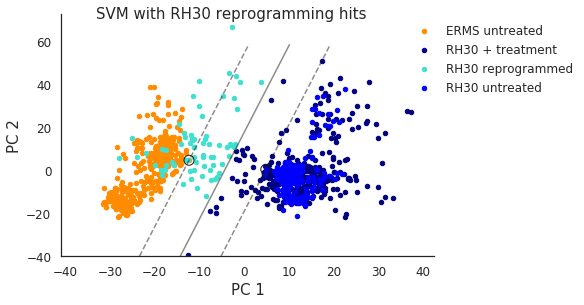

In [202]:
features_treatment = principalDf[['principal component 1', 'principal component 2']]
label_treatment = principalDf['RMS_predict']
fig, ax = plt.subplots(figsize=(6, 4))
# Removing to and right border
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# Create grid to evaluate model
xx = np.linspace(-41, max(features['principal component 1']) + 20, len(x_train))
yy = np.linspace(-40, max(features['principal component 2']) + 20, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

train_size = len(features_treatment[:-test_size]['principal component 1'])
# Assigning different colors to the classes

targets = sorted(list(set(principalDf['RMS_type'])))

colors = cycle(['darkorange','navy','turquoise','blue'])

for target, color in zip(targets,colors):
    indicesToKeep = principalDf['RMS_type'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s=20)

# Plot the dataset
# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)
# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
fig.suptitle('SVM with RH30 reprogramming hits', fontsize = 15)
plt.tight_layout()
ax.legend(targets,fontsize = 12, loc="upper right", bbox_to_anchor=(1.4, 1), frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
fig.savefig('{}/SVM_3_cell_lines_RH30_reprogrammed.png'.format(OutputDir),  dpi=150, bbox_inches='tight')
plt.show()

(1020, 2180)


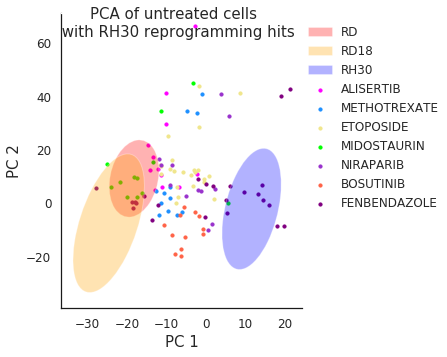

In [225]:
OneCellLine = 'RH30'
dfPart=df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'CW9019')| (df['cell_line'] == OneCellLine)] 
print(dfPart.shape)
dfPart.reset_index(inplace=True, drop=True)
x = dfPart.loc[:, varying_features].values
x = StandardScaler().fit_transform(x)
principalComponents = pca.transform(x)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                            2: 'principal component 3'}, inplace=True)

principalDf['cmpdname'] = dfPart['cmpdname']
principalDf['cell_line'] = dfPart['cell_line']
principalDf['cmpdnum'] = dfPart['cmpdnum']

RMS_class= []
RMS_type = []
for i in range (0,len(principalDf),1):
    if principalDf['cell_line'].iloc[i] in ['RD', 'RD18']:
        if principalDf['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_class.append(0)
            RMS_type.append('ERMS untreated')
        else:
            RMS_class.append(0)
            RMS_type.append('ERMS + treatment')
    else: 
        if principalDf['cmpdname'].iloc[i] == 'UNTREATED':
            RMS_class.append(1)
            RMS_type.append('RH30 untreated')
        else: 
            RMS_class.append(1)
            RMS_type.append('RH30 + treatment')
            
principalDf['RMS_class'] = RMS_class
principalDf['RMS_type'] = RMS_type

fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(111) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
# ax.set_title('Score Scatter Plote', fontsize = 15)

principalDf_ellipse = principalDf[principalDf['cmpdname'] == 'UNTREATED']
targets = CellLines
colors=[]
for target in targets: 
    colors.append(color_dict[target])

for target, color in zip(targets,colors):
    indicesToKeep_ut = principalDf_ellipse['cell_line'] == target
    
    confidence_ellipse(principalDf_ellipse.loc[indicesToKeep_ut, 'principal component 1']
               , principalDf_ellipse.loc[indicesToKeep_ut, 'principal component 2'], ax, alpha = 0.3, facecolor=color)

    
targets = hits_filtered
colors=[]
for target in targets: 
    colors.append(color_dict[target])

for target, color in zip(targets,colors):
    indicesToKeep = principalDf['cmpdname'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
    #confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
     #              , principalDf.loc[indicesToKeep, 'principal component 2'], ax,n_std=1, alpha = 0.3, facecolor=color)

targets= CellLines + hits_filtered
plt.tight_layout()
fig.legend(targets, fontsize = 12, loc="upper right",bbox_to_anchor=(1.25, 0.95), frameon=False)
fig.suptitle('PCA of untreated cells \n with {} reprogramming hits'.format(OneCellLine), fontsize = 15)
plt.subplots_adjust( wspace=0.3, right = 0.85)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_facecolor('w')

fig.savefig('{}/PCA_3_cell_lines_untreated_and_{}_reprogramming_hits.png'.format(OutputDir, OneCellLine),  dpi=150, bbox_inches='tight')
plt.show()

### Figure 7: Correlation matrix

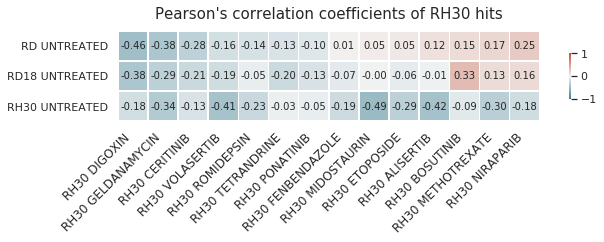

In [46]:
OneCellLine = 'RH30'
dfPart = df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'Placeholder')| (df['cell_line'] == OneCellLine)] 
dfPart['cell_cmpd'] = dfPart.cell_line + ' ' + dfPart.cmpdname
#dfPart=df[(df['cmpdname'] == 'UNTREATED') & (df['cell_line'] != 'CW9019')| (df['cell_line'] == 'RH30')]
#dfPart =dfPart[dfPart['cmpdname'].isin(hits_ut)]

dictOfnumeric = { i : np.nanmean for i in varying_features}
groupedby = dfPart.groupby('cell_cmpd').agg(dictOfnumeric)
x = groupedby.iloc[:,:].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, index = groupedby.index)
CorrMatrics = x.T.corr()
CorrMatrics = CorrMatrics.loc[['RD UNTREATED','RD18 UNTREATED','RH30 UNTREATED'],:] 
to_del=[]
for column in CorrMatrics.columns: 
    if CorrMatrics.loc['RH30 UNTREATED',column] > 0:
        to_del.append(column)
    else: continue
to_del = to_del + ['CW9019 UNTREATED']
CorrMatrics = CorrMatrics.drop(to_del, axis='columns')
CorrMatrics = CorrMatrics.sort_values(by=['RD UNTREATED','RD18 UNTREATED','RH30 UNTREATED'], axis=1)
sns.set(font_scale=1)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,3)) 

#mask = np.triu(np.ones_like(CorrMatrics, dtype=np.bool))
#for a in range(mask.shape[0]):
#    mask[a, a] = False

sns.heatmap(CorrMatrics, vmin=-1, vmax=1, linewidths=.5, ax = ax, fmt='.2f',annot_kws={'size': 10},
                 annot=True, 
                 cmap=sns.diverging_palette(220, 20, n=200),
                 cbar_kws={"shrink": 0.5},
             square=True
                )

ax.set_title('Pearson\'s correlation coefficients of {} hits'.format(OneCellLine), fontdict={'fontsize':15}, pad=12)
ax.set(xlabel=None, ylabel=None)
plt.tight_layout()
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45, fontsize =12,
    horizontalalignment='right');

fig.savefig('{}/CorrelationMatrix_{}_hits.{}'.format(OutputDir,OneCellLine, 'png'),  dpi=300, bbox_inches='tight')


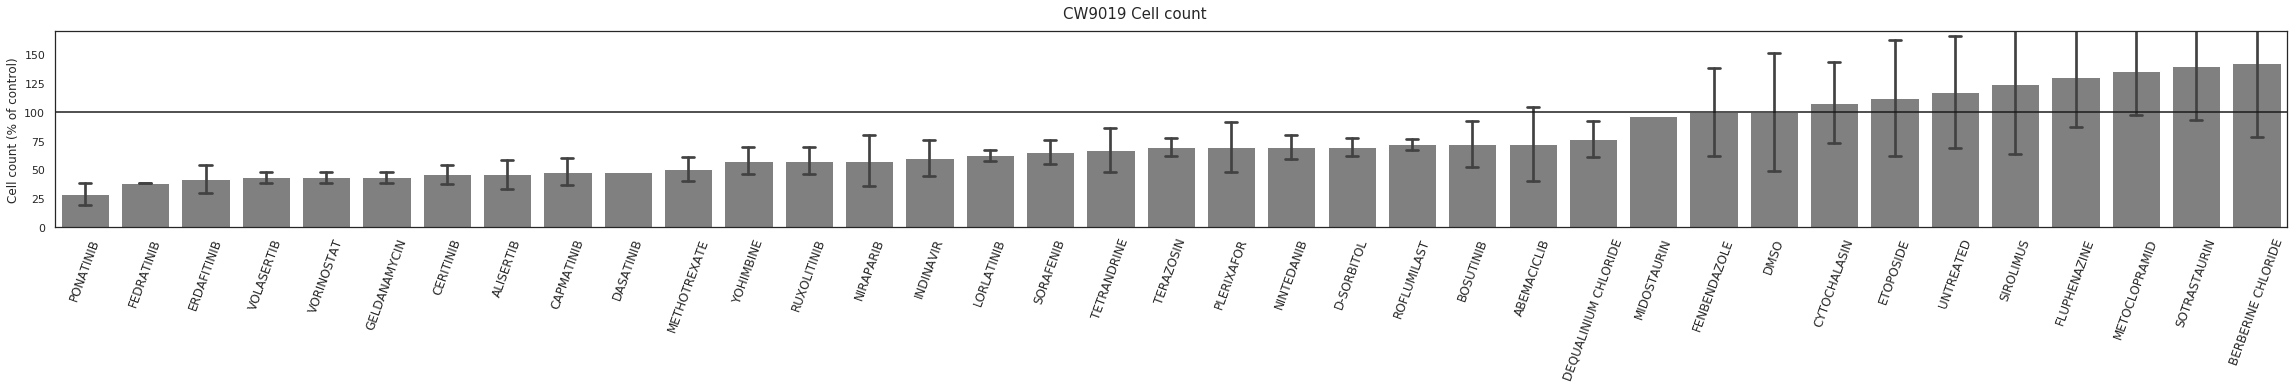

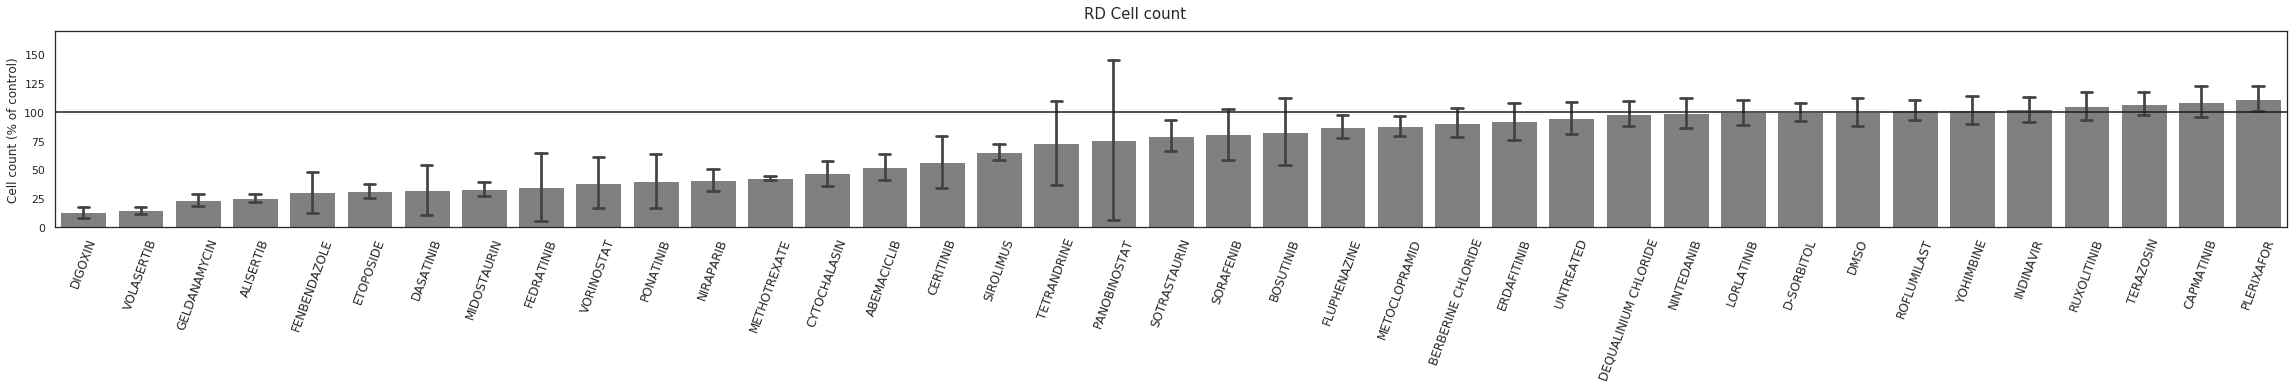

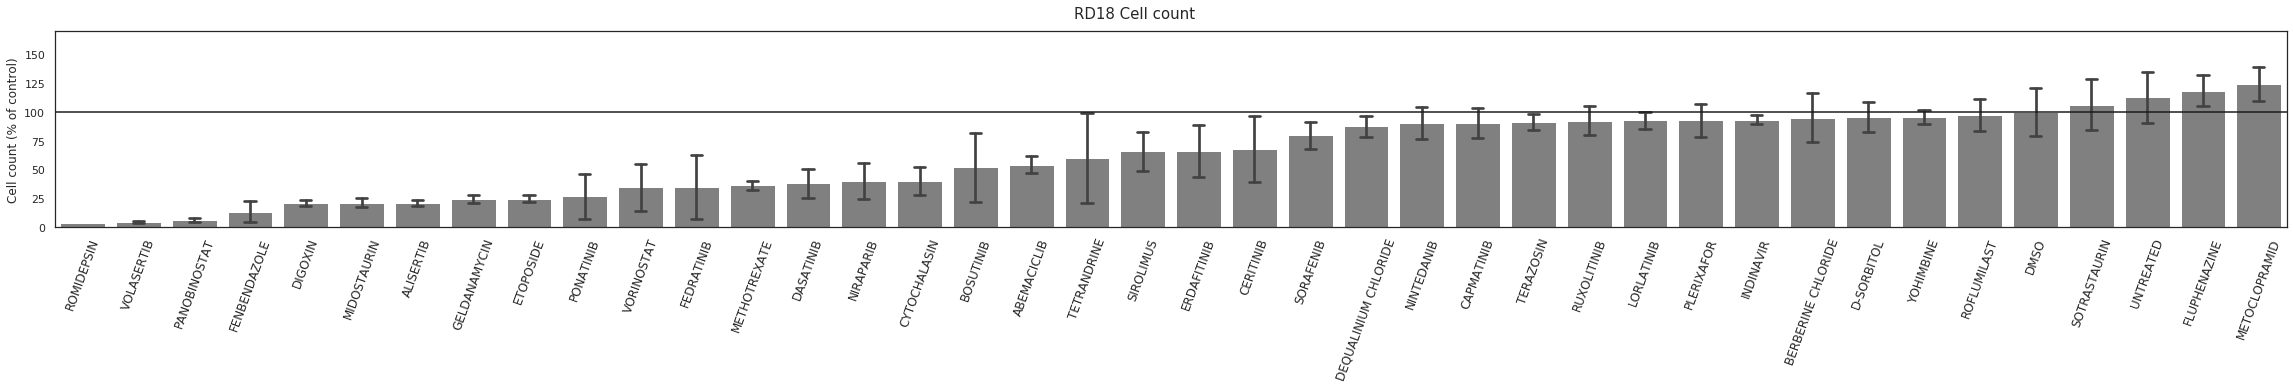

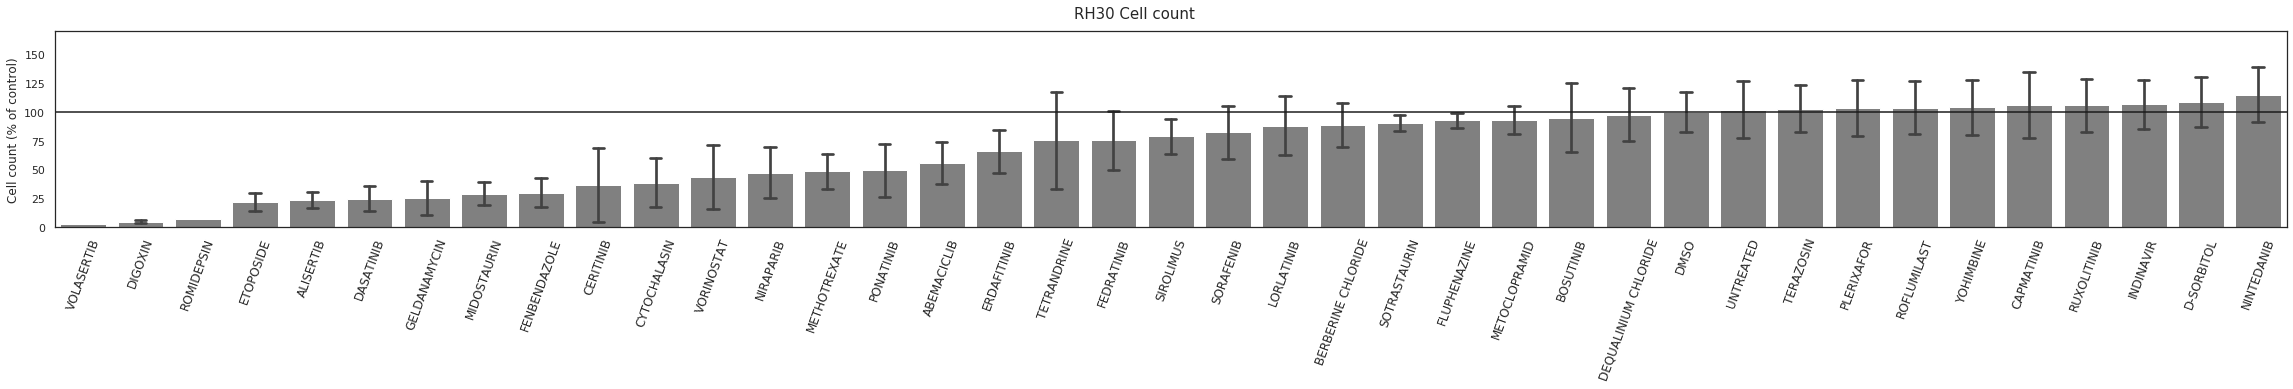

In [92]:
SomeFeature = 'Count_mean_norm'
for OneCellLine in CellLines_4:
    dfPart= df[df['cell_line'] == OneCellLine]
    dfNorm = dfPart.groupby(dfPart['cmpdname']).mean()
    dfPart['Count_mean_norm']= (dfPart.loc[:,'Image_Count_nuclei_filtered_Mean']/ dfNorm.loc['DMSO', 'Image_Count_nuclei_filtered_Mean'])*100
    
    dfSort = dfPart.groupby(dfPart['cmpdname']).mean()
    dfSort = dfSort.sort_values(by=[SomeFeature])
    
    fig = plt.figure(figsize = (40, 3.5))
    fig.suptitle('{} {}'.format(OneCellLine, 'Cell count'), fontsize = 15, y=1)
    ax = fig.add_subplot(111)
     
    plot = sns.barplot(x= 'cmpdname',y= SomeFeature, data=dfPart, order= dfSort.index, ax=ax, color='grey', capsize=.2, ci='sd')
    ax.set(xlabel=None, ylabel='Cell count (% of control)')
    plot.axhline(100, color='k')
    plt.ylim(0,170)
    plt.xticks(fontsize=12,rotation= 70)
    plt.subplots_adjust( top = 0.90)
    plt.savefig('{}/Barplot_For_{}_{}_cmpdname_grey.png'.format(OutputDir, OneCellLine, SomeFeature),dpi=150, bbox_inches='tight')

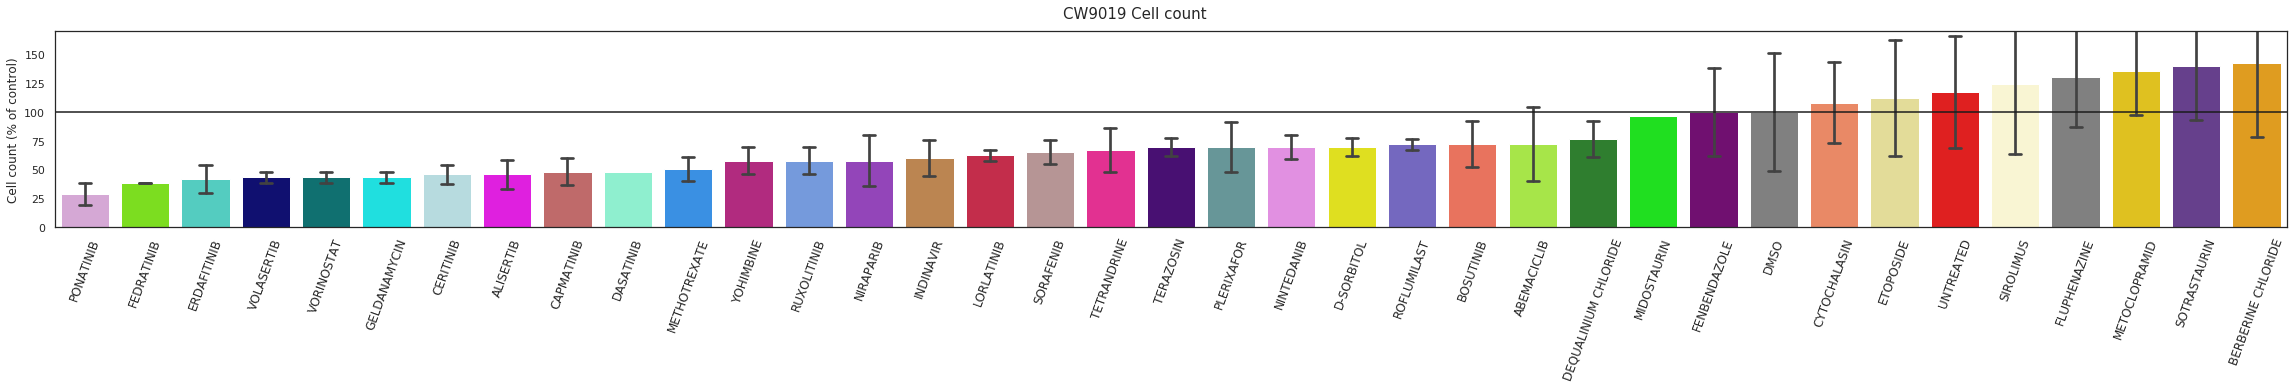

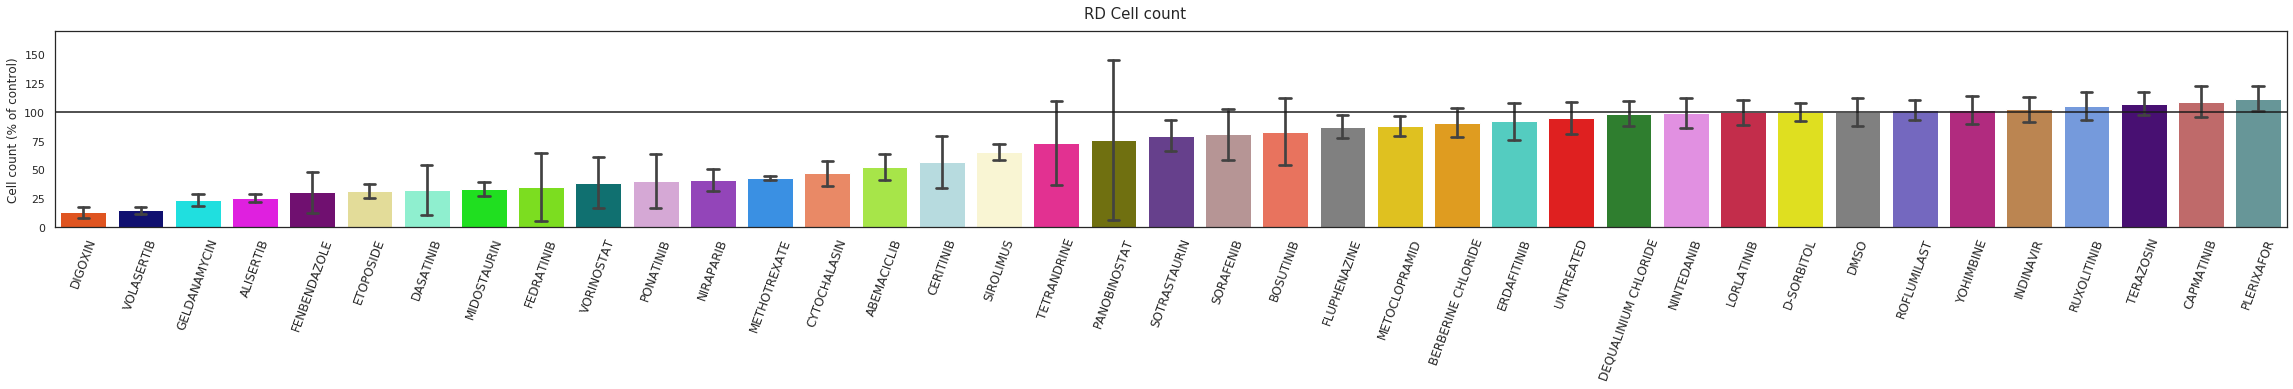

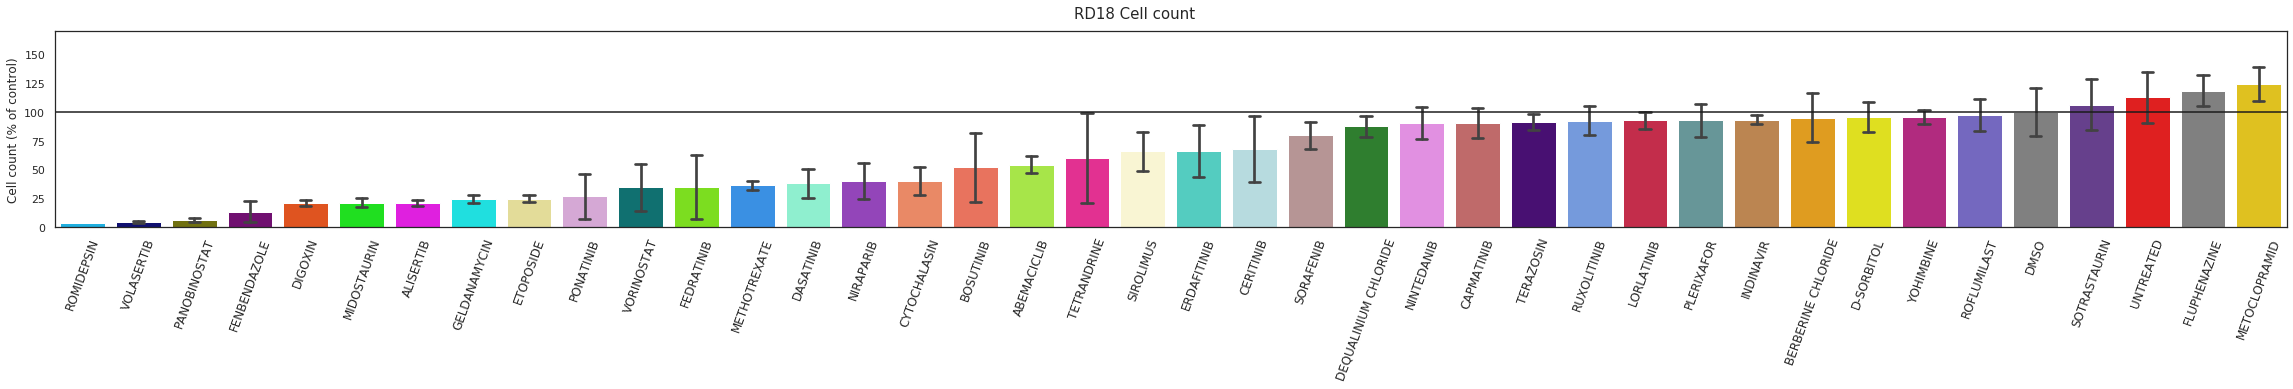

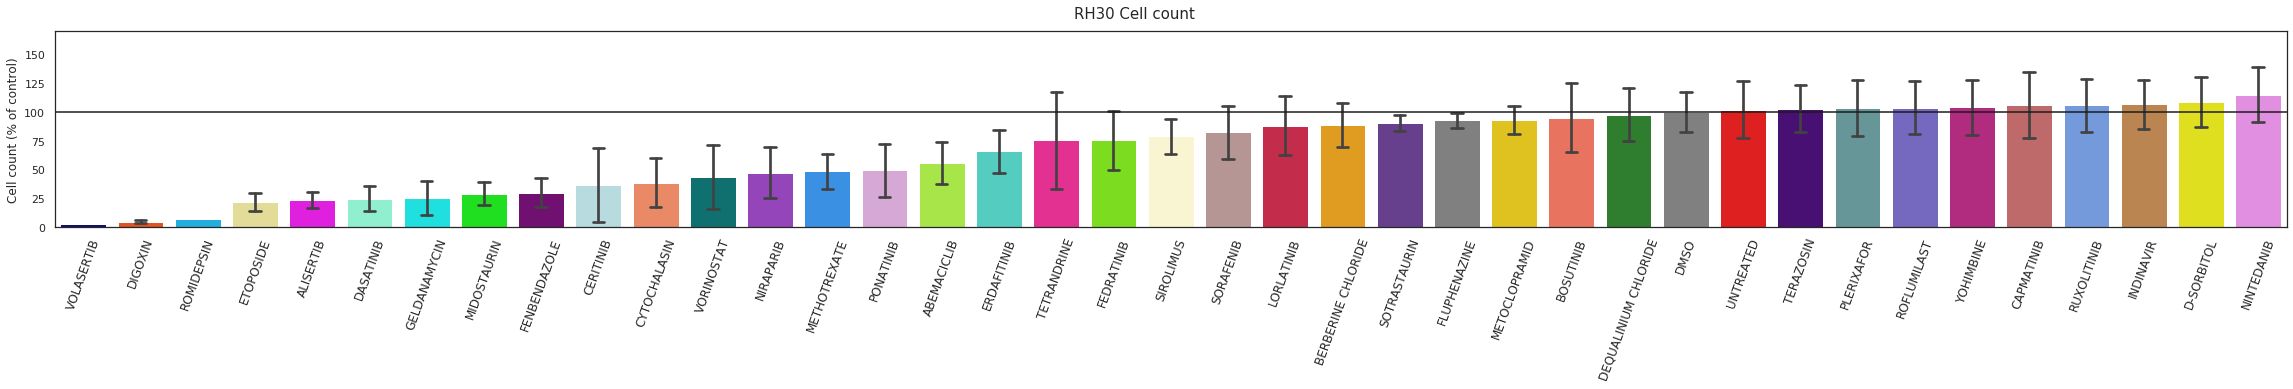

In [94]:
SomeFeature = 'Count_mean_norm'
for OneCellLine in CellLines_4:
    dfPart= df[df['cell_line'] == OneCellLine]
    dfNorm = dfPart.groupby(dfPart['cmpdname']).mean()
    dfPart['Count_mean_norm']= (dfPart.loc[:,'Image_Count_nuclei_filtered_Mean']/ dfNorm.loc['DMSO', 'Image_Count_nuclei_filtered_Mean'])*100
    
    dfSort = dfPart.groupby(dfPart['cmpdname']).mean()
    dfSort = dfSort.sort_values(by=[SomeFeature])
    
    targets = dfSort.index
    colors=[]
    for target in targets: 
        colors.append(color_dict[target])
        
    fig = plt.figure(figsize = (40, 3.5))
    fig.suptitle('{} {}'.format(OneCellLine, 'Cell count'), fontsize = 15, y=1)
    ax = fig.add_subplot(111)
     
    plot = sns.barplot(x= 'cmpdname',y= SomeFeature, data=dfPart, order= dfSort.index, ax=ax, palette=colors, capsize=.2, ci='sd')
    ax.set(xlabel=None, ylabel='Cell count (% of control)')
    plot.axhline(100, color='k')
    plt.ylim(0,170)
    plt.xticks(fontsize=12,rotation= 70)
    plt.subplots_adjust( top = 0.90)
    plt.savefig('{}/Barplot_For_{}_{}_cmpdname_color.png'.format(OutputDir, OneCellLine, SomeFeature),dpi=150, bbox_inches='tight')

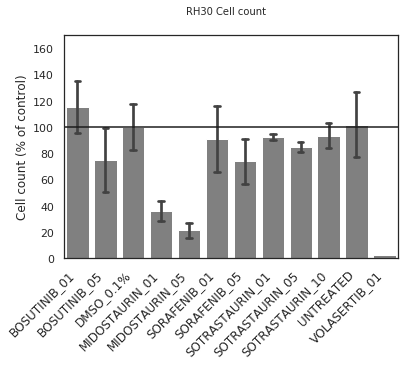

In [128]:
OneCellLine = 'RH30'
dfPart= df[df['cell_line'] == OneCellLine]
dfPart= dfPart[(df['cmpdname'] == 'MIDOSTAURIN') | (df['cmpdname'] == 'SORAFENIB')| 
               (df['cmpdname'] == 'UNTREATED') | (df['cmpdname'] == 'DMSO')
               |(df['cmpdname'] == 'SOTRASTAURIN')|(df['cmpdname'] == 'VOLASERTIB')|(df['cmpdname'] == 'BOSUTINIB') ]
dfNorm = dfPart.groupby(dfPart['cmpdname']).mean()
dfPart['Count_mean_norm']= (dfPart.loc[:,'Image_Count_nuclei_filtered_Mean']/ dfNorm.loc['DMSO', 'Image_Count_nuclei_filtered_Mean'])*100

dfSort = dfPart.groupby(dfPart['cmpdnum']).mean()
dfSort = dfSort.sort_values(by=['cmpdnum'])

fig = plt.figure(figsize = (6, 4))
fig.suptitle('{} {}'.format(OneCellLine, 'Cell count'), fontsize = 10, y=1)
ax = fig.add_subplot(111)

plot = sns.barplot(x= 'cmpdnum',y= SomeFeature, data=dfPart, order=dfSort.index, ax=ax,  color='gray', capsize=.2, ci='sd')
ax.set(xlabel=None, ylabel='Cell count (% of control)')
plot.axhline(100, color='k')
plt.ylim(0,170)
plt.xticks(fontsize=12,rotation= 45)
ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right')
plt.subplots_adjust( top = 0.90)
plt.savefig('{}/Barplot_For_{}_{}_filtered.png'.format(OutputDir, OneCellLine, SomeFeature),dpi=150, bbox_inches='tight')

In [ ]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

### XXXXXXXXXXXXXXXXX